In [1]:
!pip install gdown

# Importing Libraries

In [2]:
import gdown
import pandas as pd
import matplotlib.pyplot as plt

import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

import torch
from torch.utils.data import DataLoader
from datasets import Dataset

from transformers import AdamW, BertTokenizer, BertForTokenClassification, Trainer, TrainingArguments

# Importing Data

In [3]:
gdown.download("https://drive.google.com/uc?id=1UaYztrYKffzDcvgCRQMT7c4I6HrLloDm", '/kaggle/working/com.csv', quiet=False)
print('/kaggle/working/data.csv')

Downloading...
From: https://drive.google.com/uc?id=1UaYztrYKffzDcvgCRQMT7c4I6HrLloDm
To: /kaggle/working/com.csv
100%|██████████| 430k/430k [00:00<00:00, 91.7MB/s]

/kaggle/working/data.csv


In [4]:
com = pd.read_csv("/kaggle/working/com.csv")
com.head()

,text,comp,en1,en2
0,لابتوب اسوس افضل من لابتوبات ابل ؟ احس مستحيل ...,1,اسوس,ابل
1,اسوس افضل من وجهة نظري,1,اسوس,NaN
2,كلهم نفس المواصفات مافي فرق اسوس افضل من hp في...,1,اسوس,hp
3,التخصصات الهندسية بالذات الحاسب والبرمجيات ماي...,1,اسوس,NaN
4,اسوس افضل من ناحية التنوع والاسعار والعروض,1,اسوس,NaN


# Data Preprocessing

In [52]:
train_df, test_df = train_test_split(com, test_size=0.2, random_state=42)

In [53]:
# Load the tokenizer and the model
tokenizer = BertTokenizer.from_pretrained("aubmindlab/bert-base-arabertv02-twitter")
model = BertForTokenClassification.from_pretrained("aubmindlab/bert-base-arabertv02-twitter", num_labels=3)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv02-twitter and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [54]:
# Calculate the maximum length in terms of whitespace-separated words
max_length = max(len(tokenizer(text)["input_ids"]) for text in com['text'])
max_length

107

In [55]:
# Function to split en1 or en2 values and handle "nan" string values
def split_values(val):
    if pd.isna(val) or val == "nan":  # Check if value is NaN or "nan" string
        return []
    return [item.strip() for item in re.split(r'[ ,]+', val) if item.strip()]

# Tokenization function for text with labels for en1 and en2
def tokenize_data(example):
    text = example["text"]
    tokens = tokenizer(text, padding="max_length", truncation=True, max_length=max_length)

    # Generate labels
    labels = [0] * len(tokens["input_ids"])  # Default label for non-entity tokens

    # Process and tokenize en1 and en2 entities
    en1_entities = split_values(example["en1"])
    en2_entities = split_values(example["en2"])

    en1_tokens = [tokenizer.tokenize(entity) for entity in en1_entities]
    en2_tokens = [tokenizer.tokenize(entity) for entity in en2_entities]

    # Match tokens and assign labels
    for i, token_id in enumerate(tokens["input_ids"]):
        token_str = tokenizer.convert_ids_to_tokens([token_id])[0]
        for entity_tokens in en1_tokens:
            if token_str in entity_tokens:
                labels[i] = 1  # Label for en1
        for entity_tokens in en2_tokens:
            if token_str in entity_tokens:
                labels[i] = 2  # Label for en2

    tokens["label"] = labels
    return tokens

In [56]:
# Convert the pandas DataFrame to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

In [57]:
# Apply the tokenization function to both datasets
train_dataset = train_dataset.map(tokenize_data, batched=False)
test_dataset = test_dataset.map(tokenize_data, batched=False)

Map:   0%|          | 0/1861 [00:00<?, ? examples/s]

Map:   0%|          | 0/466 [00:00<?, ? examples/s]

In [58]:
# Set the dataset format for PyTorch
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

In [59]:
# Create DataLoader for training and testing
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8)

In [60]:
# Freeze all layers except the classifier and last 2 layers
for param in model.parameters():
    param.requires_grad = False

for param in model.bert.encoder.layer[-2:].parameters():
    param.requires_grad = True

for param in model.classifier.parameters():
    param.requires_grad = True

In [61]:
# Define the optimizer and device
optimizer = AdamW(model.parameters(), lr=3e-5, weight_decay=.03)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(device)

cuda


/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [62]:
# Initialize lists to store metrics
train_losses, test_losses = [], []
train_f1_scores, test_f1_scores = [], []

# Training and validation loop
for epoch in range(10):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    # Training
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        preds = torch.argmax(outputs.logits, dim=-1)
        all_preds.extend(preds.cpu().numpy().flatten())
        all_labels.extend(labels.cpu().numpy().flatten())

    # Calculate training metrics
    train_loss = total_loss / len(train_loader)
    train_losses.append(train_loss)
    train_f1 = f1_score(all_labels, all_preds, average="macro", zero_division=0)
    train_f1_scores.append(train_f1)

    # Validation
    model.eval()
    test_preds = []
    test_labels = []
    test_loss = 0

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            test_loss += loss.item()

            preds = torch.argmax(outputs.logits, dim=-1)
            test_preds.extend(preds.cpu().numpy().flatten())
            test_labels.extend(labels.cpu().numpy().flatten())

    # Calculate validation metrics
    test_loss /= len(test_loader)
    test_losses.append(test_loss)
    test_f1 = f1_score(test_labels, test_preds, average="macro", zero_division=0)
    test_f1_scores.append(test_f1)

    print(f"Epoch {epoch + 1}")
    print(f"Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")
    print(f"Train F1 Score: {train_f1:.4f}, Test F1 Score: {test_f1:.4f}")

Epoch 1
Train Loss: 0.0719, Test Loss: 0.0345
Train F1 Score: 0.6791, Test F1 Score: 0.8611
Epoch 2
Train Loss: 0.0331, Test Loss: 0.0277
Train F1 Score: 0.8592, Test F1 Score: 0.8836
Epoch 3
Train Loss: 0.0276, Test Loss: 0.0260
Train F1 Score: 0.8808, Test F1 Score: 0.8907
Epoch 4
Train Loss: 0.0242, Test Loss: 0.0231
Train F1 Score: 0.8933, Test F1 Score: 0.9049
Epoch 5
Train Loss: 0.0215, Test Loss: 0.0218
Train F1 Score: 0.9051, Test F1 Score: 0.9092
Epoch 6
Train Loss: 0.0189, Test Loss: 0.0245
Train F1 Score: 0.9173, Test F1 Score: 0.9032
Epoch 7
Train Loss: 0.0169, Test Loss: 0.0217
Train F1 Score: 0.9237, Test F1 Score: 0.9166
Epoch 8
Train Loss: 0.0147, Test Loss: 0.0217
Train F1 Score: 0.9348, Test F1 Score: 0.9124
Epoch 9
Train Loss: 0.0125, Test Loss: 0.0221
Train F1 Score: 0.9450, Test F1 Score: 0.9167
Epoch 10
Train Loss: 0.0109, Test Loss: 0.0218
Train F1 Score: 0.9520, Test F1 Score: 0.9237


# Evaluation

In [63]:
# Evaluation loop
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=-1)

        all_preds.extend(preds.cpu().numpy().flatten())
        all_labels.extend(labels.cpu().numpy().flatten())

# Calculate evaluation metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average="macro", labels=[0, 1, 2], zero_division=0)
recall = recall_score(all_labels, all_preds, average="macro", labels=[0, 1, 2], zero_division=0)
Avg_f1 = f1_score(all_labels, all_preds, average="macro", zero_division=0)
f1 = f1_score(all_labels, all_preds, average=None, labels=[0, 1, 2], zero_division=0)

print(f"Test Accuracy: {accuracy}")
print(f"Test Precision: {precision}")
print(f"Test Recall: {recall}")
print(f"Test Avg F1 Score: {Avg_f1}")
print(f"Test F1 Score: {f1}")

Test Accuracy: 0.9937627852873933
Test Precision: 0.9369221500699257
Test Recall: 0.9111735854952708
Test Avg F1 Score: 0.9237140070517423
Test F1 Score: [0.9971441  0.90840652 0.8655914 ]


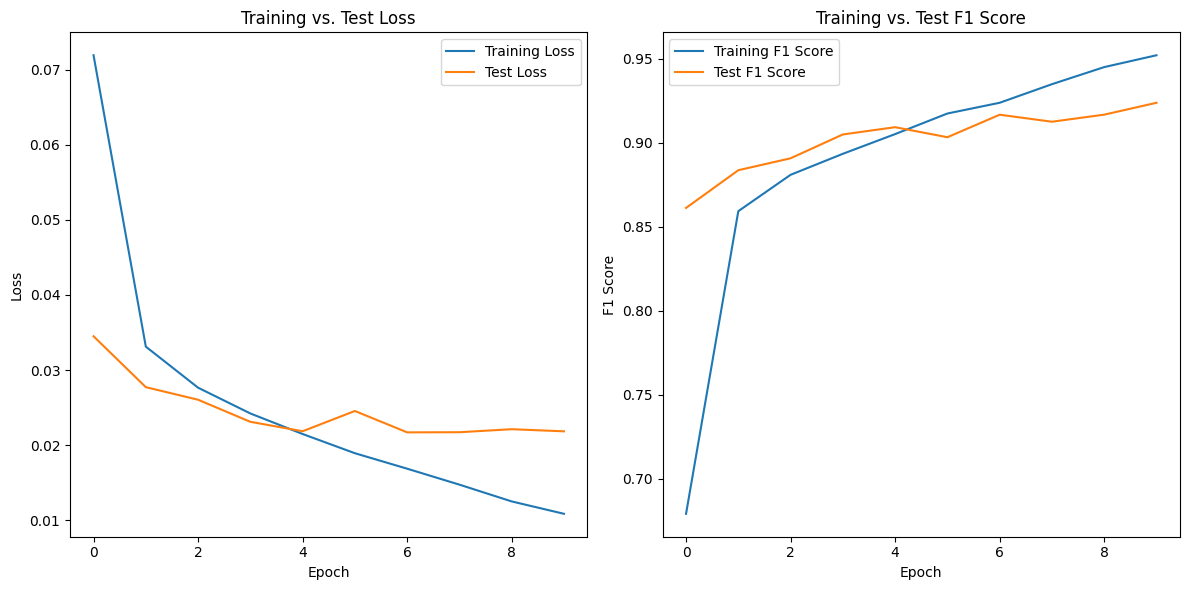

In [64]:
# Plot learning curves
plt.figure(figsize=(12, 6))

# Loss curves
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs. Test Loss")
plt.legend()

# F1 Score curves
plt.subplot(1, 2, 2)
plt.plot(train_f1_scores, label="Training F1 Score")
plt.plot(test_f1_scores, label="Test F1 Score")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title("Training vs. Test F1 Score")
plt.legend()

plt.tight_layout()
plt.show()

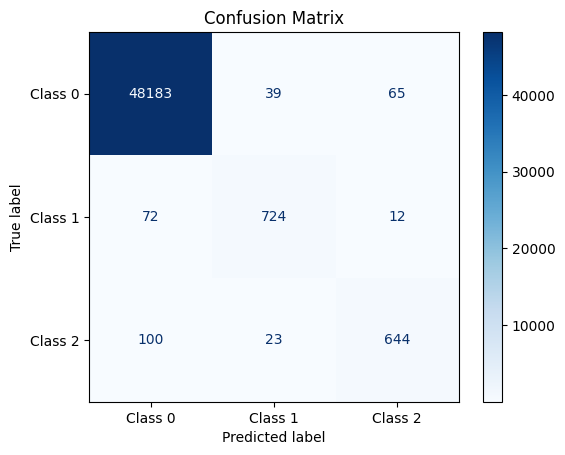

In [65]:
# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1", "Class 2"])

# Plot
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()